# Store Sales Time Series Forecasting - Exploratory Data Analysis


## Dataset Description
The dataset contains sales data for Favorita stores in Ecuador, including:
- **train.csv**: Historical sales data (3M+ records)
- **test.csv**: Test data for predictions (28K+ records) 
- **stores.csv**: Store information (55 stores)
- **holidays_events.csv**: Holiday and event data (351 records)
- **oil.csv**: Daily oil prices (1,219 records)
- **transactions.csv**: Transaction data (83K+ records)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

Libraries imported successfully!


## 1. Data Loading and Initial Inspection

In [6]:
# Load all datasets
def load_data(date_columns):
    """Load all the datasets and return them as a dictionary"""
    
    data_path = "store-sales-time-series-forecasting/"
    
    datasets = {}
    
    # Load main datasets
    print("Loading datasets...")
    datasets['train'] = pd.read_csv(f"{data_path}train.csv")
    datasets['test'] = pd.read_csv(f"{data_path}test.csv")
    datasets['stores'] = pd.read_csv(f"{data_path}stores.csv")
    datasets['holidays'] = pd.read_csv(f"{data_path}holidays_events.csv")
    datasets['oil'] = pd.read_csv(f"{data_path}oil.csv")
    datasets['transactions'] = pd.read_csv(f"{data_path}transactions.csv")
    
    # # Convert date columns to datetime
    # date_columns = {
    #     'train': 'date',
    #     'test': 'date', 
    #     'holidays': 'date',
    #     'oil': 'date',
    #     'transactions': 'date'
    # }
    
    for dataset_name, date_col in date_columns.items():
        if dataset_name in datasets:
            datasets[dataset_name][date_col] = pd.to_datetime(datasets[dataset_name][date_col])
    
    print("All datasets loaded successfully!")
    return datasets

# Load the data
date_columns = {'train': 'date', 'test': 'date', 'holidays': 'date', 'oil': 'date', 'transactions': 'date'}
data = load_data(date_columns)

# Display basic information about each dataset
print("\n=== DATASET OVERVIEW ===")
for name, df in data.items():
    print(f"\n{name.upper()} Dataset:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {list(df.columns)}")
    print(f"  Date range: {df[date_columns.get(name, 'date')].min()} to {df[date_columns.get(name, 'date')].max()}" if date_columns.get(name) in df.columns else "  No date column")


Loading datasets...
All datasets loaded successfully!

=== DATASET OVERVIEW ===

TRAIN Dataset:
  Shape: (3000888, 6)
  Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']
  Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

TEST Dataset:
  Shape: (28512, 5)
  Columns: ['id', 'date', 'store_nbr', 'family', 'onpromotion']
  Date range: 2017-08-16 00:00:00 to 2017-08-31 00:00:00

STORES Dataset:
  Shape: (54, 5)
  Columns: ['store_nbr', 'city', 'state', 'type', 'cluster']
  No date column

HOLIDAYS Dataset:
  Shape: (350, 6)
  Columns: ['date', 'type', 'locale', 'locale_name', 'description', 'transferred']
  Date range: 2012-03-02 00:00:00 to 2017-12-26 00:00:00

OIL Dataset:
  Shape: (1218, 2)
  Columns: ['date', 'dcoilwtico']
  Date range: 2013-01-01 00:00:00 to 2017-08-31 00:00:00

TRANSACTIONS Dataset:
  Shape: (83488, 3)
  Columns: ['date', 'store_nbr', 'transactions']
  Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00


## 2. Sales Data Analysis


In [7]:
# Basic sales statistics
train_df = data['train']

print("=== SALES STATISTICS ===")
print(f"Total Sales Records: {len(train_df):,}")
print(f"Total Sales Value: ${train_df['sales'].sum():,.2f}")
print(f"Average Daily Sales: ${train_df['sales'].mean():.2f}")
print(f"Median Daily Sales: ${train_df['sales'].median():.2f}")
print(f"Sales Standard Deviation: ${train_df['sales'].std():.2f}")

print(f"\nSales Distribution:")
print(train_df['sales'].describe())

# Check for zero and negative sales
zero_sales = (train_df['sales'] == 0).sum()
negative_sales = (train_df['sales'] < 0).sum()
print(f"\nZero Sales Records: {zero_sales:,} ({zero_sales/len(train_df)*100:.2f}%)")
print(f"Negative Sales Records: {negative_sales:,} ({negative_sales/len(train_df)*100:.2f}%)")

# Sales by store and family
print(f"\nUnique Stores: {train_df['store_nbr'].nunique()}")
print(f"Unique Product Families: {train_df['family'].nunique()}")
print(f"Date Range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Time Period: {(train_df['date'].max() - train_df['date'].min()).days} days")


=== SALES STATISTICS ===
Total Sales Records: 3,000,888
Total Sales Value: $1,073,644,952.20
Average Daily Sales: $357.78
Median Daily Sales: $11.00
Sales Standard Deviation: $1102.00

Sales Distribution:
count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

Zero Sales Records: 939,130 (31.30%)
Negative Sales Records: 0 (0.00%)

Unique Stores: 54
Unique Product Families: 33
Date Range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Time Period: 1687 days


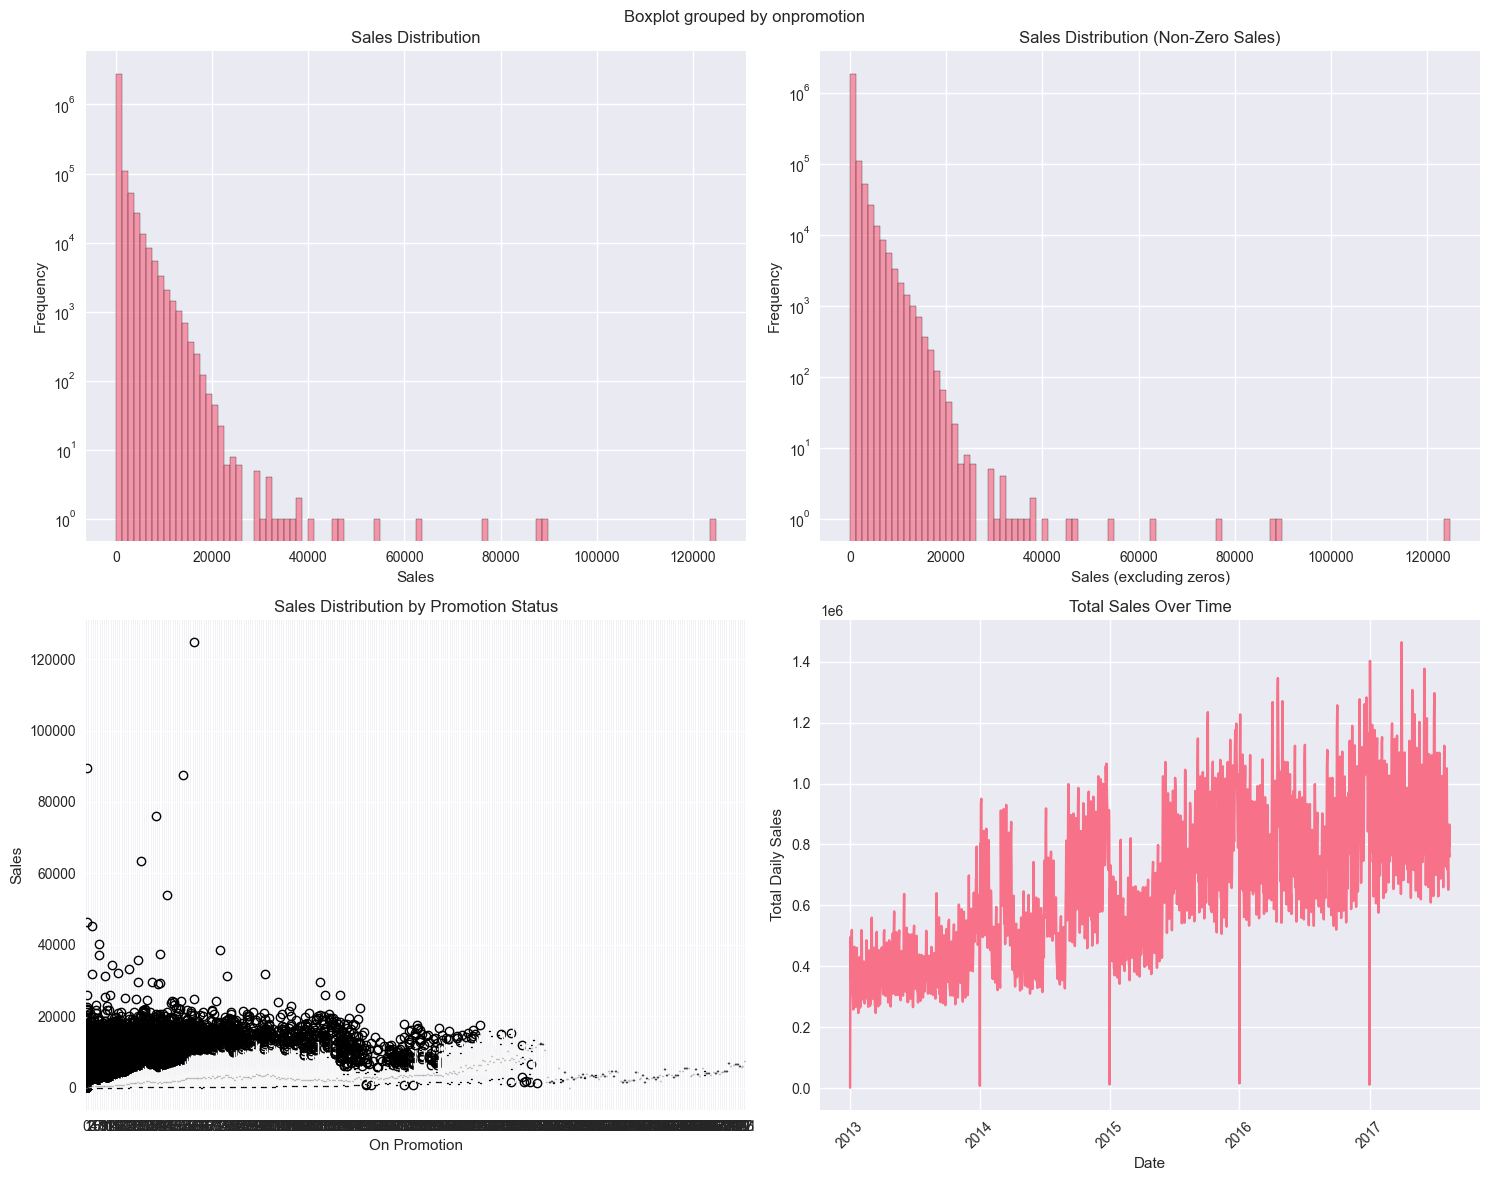

In [8]:
# Visualize sales distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sales distribution (log scale due to wide range)
axes[0, 0].hist(train_df['sales'], bins=100, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Sales')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Sales Distribution')
axes[0, 0].set_yscale('log')

# Sales distribution (excluding zeros for better view)
non_zero_sales = train_df[train_df['sales'] > 0]['sales']
axes[0, 1].hist(non_zero_sales, bins=100, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Sales (excluding zeros)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Sales Distribution (Non-Zero Sales)')
axes[0, 1].set_yscale('log')

# Box plot of sales by promotion
train_df.boxplot(column='sales', by='onpromotion', ax=axes[1, 0])
axes[1, 0].set_title('Sales Distribution by Promotion Status')
axes[1, 0].set_xlabel('On Promotion')
axes[1, 0].set_ylabel('Sales')

# Sales over time (daily aggregation)
daily_sales = train_df.groupby('date')['sales'].sum().reset_index()
axes[1, 1].plot(daily_sales['date'], daily_sales['sales'])
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Total Daily Sales')
axes[1, 1].set_title('Total Sales Over Time')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 3. Product Family Analysis


=== TOP 10 PRODUCT FAMILIES BY TOTAL SALES ===
                Total_Sales  Mean_Sales  Std_Sales  Count_Records  \
family                                                              
GROCERY I      3.434627e+08     3776.97    2874.21          90936   
BEVERAGES      2.169545e+08     2385.79    2307.88          90936   
PRODUCE        1.227047e+08     1349.35    2186.48          90936   
CLEANING       9.752129e+07     1072.42     734.68          90936   
DAIRY          6.448771e+07      709.15     671.95          90936   
BREAD/BAKERY   4.213395e+07      463.34     368.25          90936   
POULTRY        3.187600e+07      350.53     400.51          90936   
MEATS          3.108647e+07      341.85     455.91          90936   
PERSONAL CARE  2.459205e+07      270.43     226.51          90936   
DELI           2.411032e+07      265.14     210.42          90936   

               Promotion_Rate  
family                         
GROCERY I               21.06  
BEVERAGES                9.9

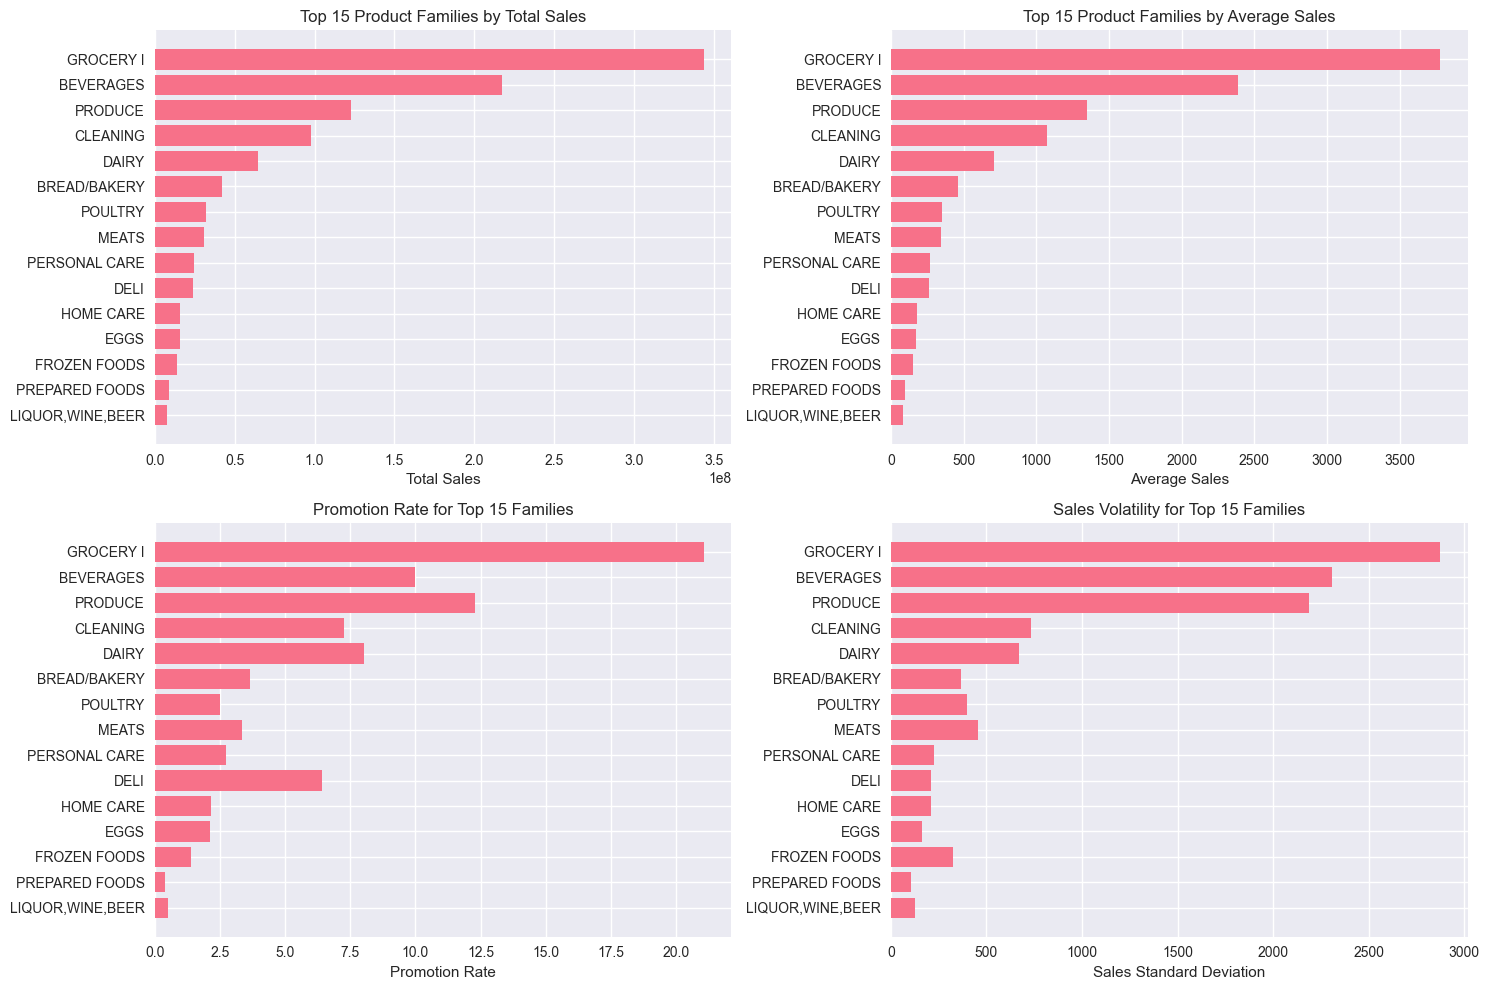

In [9]:
# Analyze sales by product family
family_sales = train_df.groupby('family').agg({
    'sales': ['sum', 'mean', 'std', 'count'],
    'onpromotion': 'mean'
}).round(2)

family_sales.columns = ['Total_Sales', 'Mean_Sales', 'Std_Sales', 'Count_Records', 'Promotion_Rate']
family_sales = family_sales.sort_values('Total_Sales', ascending=False)

print("=== TOP 10 PRODUCT FAMILIES BY TOTAL SALES ===")
print(family_sales.head(10))

print("\n=== BOTTOM 10 PRODUCT FAMILIES BY TOTAL SALES ===")
print(family_sales.tail(10))

# Visualize top product families
plt.figure(figsize=(15, 10))

# Top 15 families by total sales
top_families = family_sales.head(15)

plt.subplot(2, 2, 1)
plt.barh(range(len(top_families)), top_families['Total_Sales'])
plt.yticks(range(len(top_families)), top_families.index)
plt.xlabel('Total Sales')
plt.title('Top 15 Product Families by Total Sales')
plt.gca().invert_yaxis()

# Average sales per transaction
plt.subplot(2, 2, 2)
plt.barh(range(len(top_families)), top_families['Mean_Sales'])
plt.yticks(range(len(top_families)), top_families.index)
plt.xlabel('Average Sales')
plt.title('Top 15 Product Families by Average Sales')
plt.gca().invert_yaxis()

# Promotion rate
plt.subplot(2, 2, 3)
plt.barh(range(len(top_families)), top_families['Promotion_Rate'])
plt.yticks(range(len(top_families)), top_families.index)
plt.xlabel('Promotion Rate')
plt.title('Promotion Rate for Top 15 Families')
plt.gca().invert_yaxis()

# Sales volatility (standard deviation)
plt.subplot(2, 2, 4)
plt.barh(range(len(top_families)), top_families['Std_Sales'])
plt.yticks(range(len(top_families)), top_families.index)
plt.xlabel('Sales Standard Deviation')
plt.title('Sales Volatility for Top 15 Families')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


## 4. Temporal Patterns and Seasonality


=== TEMPORAL SALES PATTERNS ===
Sales by Year:
  2013: $140,419,013.92
  2014: $209,474,246.30
  2015: $240,880,100.65
  2016: $288,654,522.95
  2017: $194,217,068.37

Average Sales by Quarter:
  Q1: $338.83
  Q2: $344.82
  Q3: $358.26
  Q4: $396.89

Average Sales by Month:
  Jan: $341.92
  Feb: $320.93
  Mar: $352.01
  Apr: $339.20
  May: $341.77
  Jun: $353.60
  Jul: $374.22
  Aug: $336.99
  Sep: $362.30
  Oct: $362.41
  Nov: $375.68
  Dec: $453.74

Average Sales by Day of Week:
  Monday: $346.54
  Tuesday: $319.82
  Wednesday: $332.91
  Thursday: $283.54
  Friday: $325.24
  Saturday: $433.34
  Sunday: $463.09


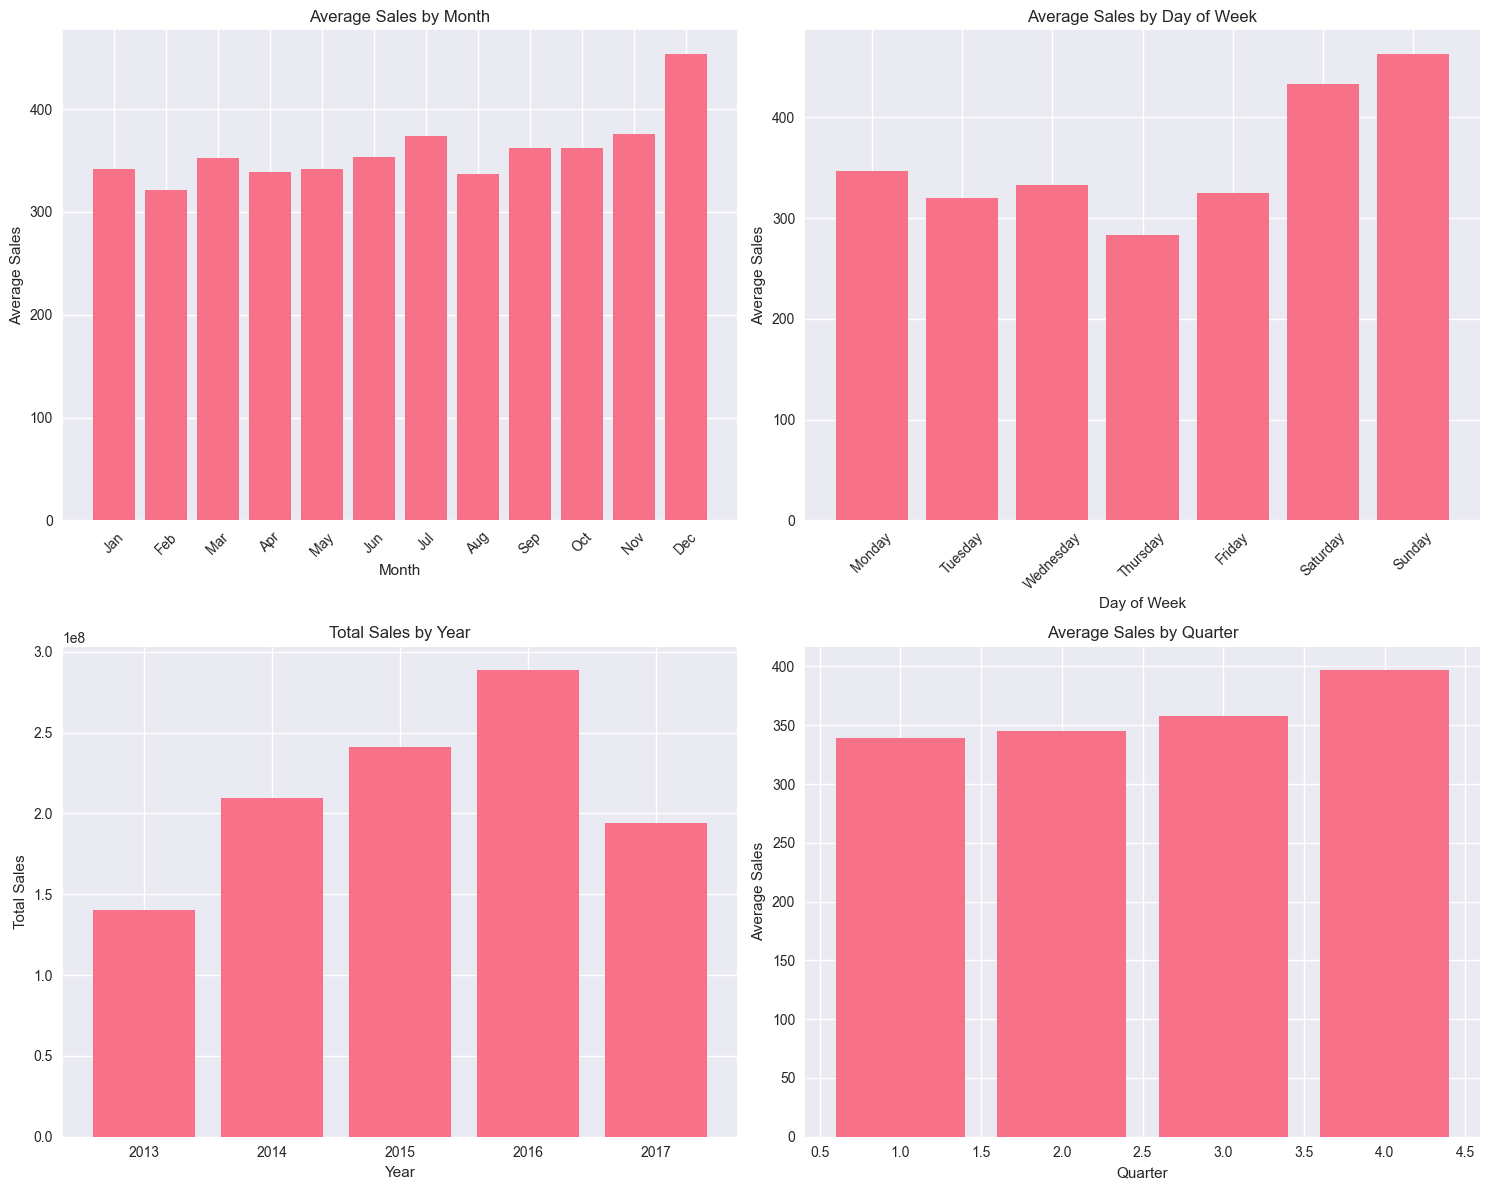

In [10]:
# Create temporal features for analysis
train_temporal = train_df.copy()
train_temporal['year'] = train_temporal['date'].dt.year
train_temporal['month'] = train_temporal['date'].dt.month
train_temporal['day'] = train_temporal['date'].dt.day
train_temporal['dayofweek'] = train_temporal['date'].dt.dayofweek
train_temporal['weekofyear'] = train_temporal['date'].dt.isocalendar().week
train_temporal['quarter'] = train_temporal['date'].dt.quarter

# Day names for better visualization
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Aggregate sales by different time periods
yearly_sales = train_temporal.groupby('year')['sales'].sum()
monthly_sales = train_temporal.groupby('month')['sales'].mean()
daily_sales = train_temporal.groupby('dayofweek')['sales'].mean()
quarterly_sales = train_temporal.groupby('quarter')['sales'].mean()

print("=== TEMPORAL SALES PATTERNS ===")
print(f"Sales by Year:")
for year, sales in yearly_sales.items():
    print(f"  {year}: ${sales:,.2f}")

print(f"\nAverage Sales by Quarter:")
for quarter, sales in quarterly_sales.items():
    print(f"  Q{quarter}: ${sales:.2f}")

print(f"\nAverage Sales by Month:")
for month, sales in monthly_sales.items():
    print(f"  {month_names[month-1]}: ${sales:.2f}")

print(f"\nAverage Sales by Day of Week:")
for day, sales in daily_sales.items():
    print(f"  {day_names[day]}: ${sales:.2f}")

# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Monthly pattern
axes[0, 0].bar(range(1, 13), monthly_sales.values)
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Average Sales')
axes[0, 0].set_title('Average Sales by Month')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(month_names, rotation=45)

# Day of week pattern
axes[0, 1].bar(range(7), daily_sales.values)
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Average Sales')
axes[0, 1].set_title('Average Sales by Day of Week')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names, rotation=45)

# Yearly pattern
axes[1, 0].bar(yearly_sales.index, yearly_sales.values)
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Total Sales')
axes[1, 0].set_title('Total Sales by Year')

# Quarterly pattern
axes[1, 1].bar(quarterly_sales.index, quarterly_sales.values)
axes[1, 1].set_xlabel('Quarter')
axes[1, 1].set_ylabel('Average Sales')
axes[1, 1].set_title('Average Sales by Quarter')

plt.tight_layout()
plt.show()


## 5. External Factors Analysis


=== OIL PRICE ANALYSIS ===
Oil price records: 1218
Date range: 2013-01-01 00:00:00 to 2017-08-31 00:00:00
Missing oil prices: 43
Oil price statistics:
count    1218.000000
mean       67.692159
std        25.629744
min        26.190000
25%        46.422500
50%        53.200000
75%        95.685000
max       110.620000
Name: dcoilwtico, dtype: float64

=== HOLIDAYS ANALYSIS ===
Holiday records: 350
Holiday types: type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64
Holiday locales: locale
National    174
Local       152
Regional     24
Name: count, dtype: int64

Correlation between oil prices and daily sales: -0.6900

=== HOLIDAY IMPACT ===
                  mean           sum    count
is_holiday                                   
False       352.159181  8.986482e+08  2551824
True        389.692123  1.749967e+08   449064


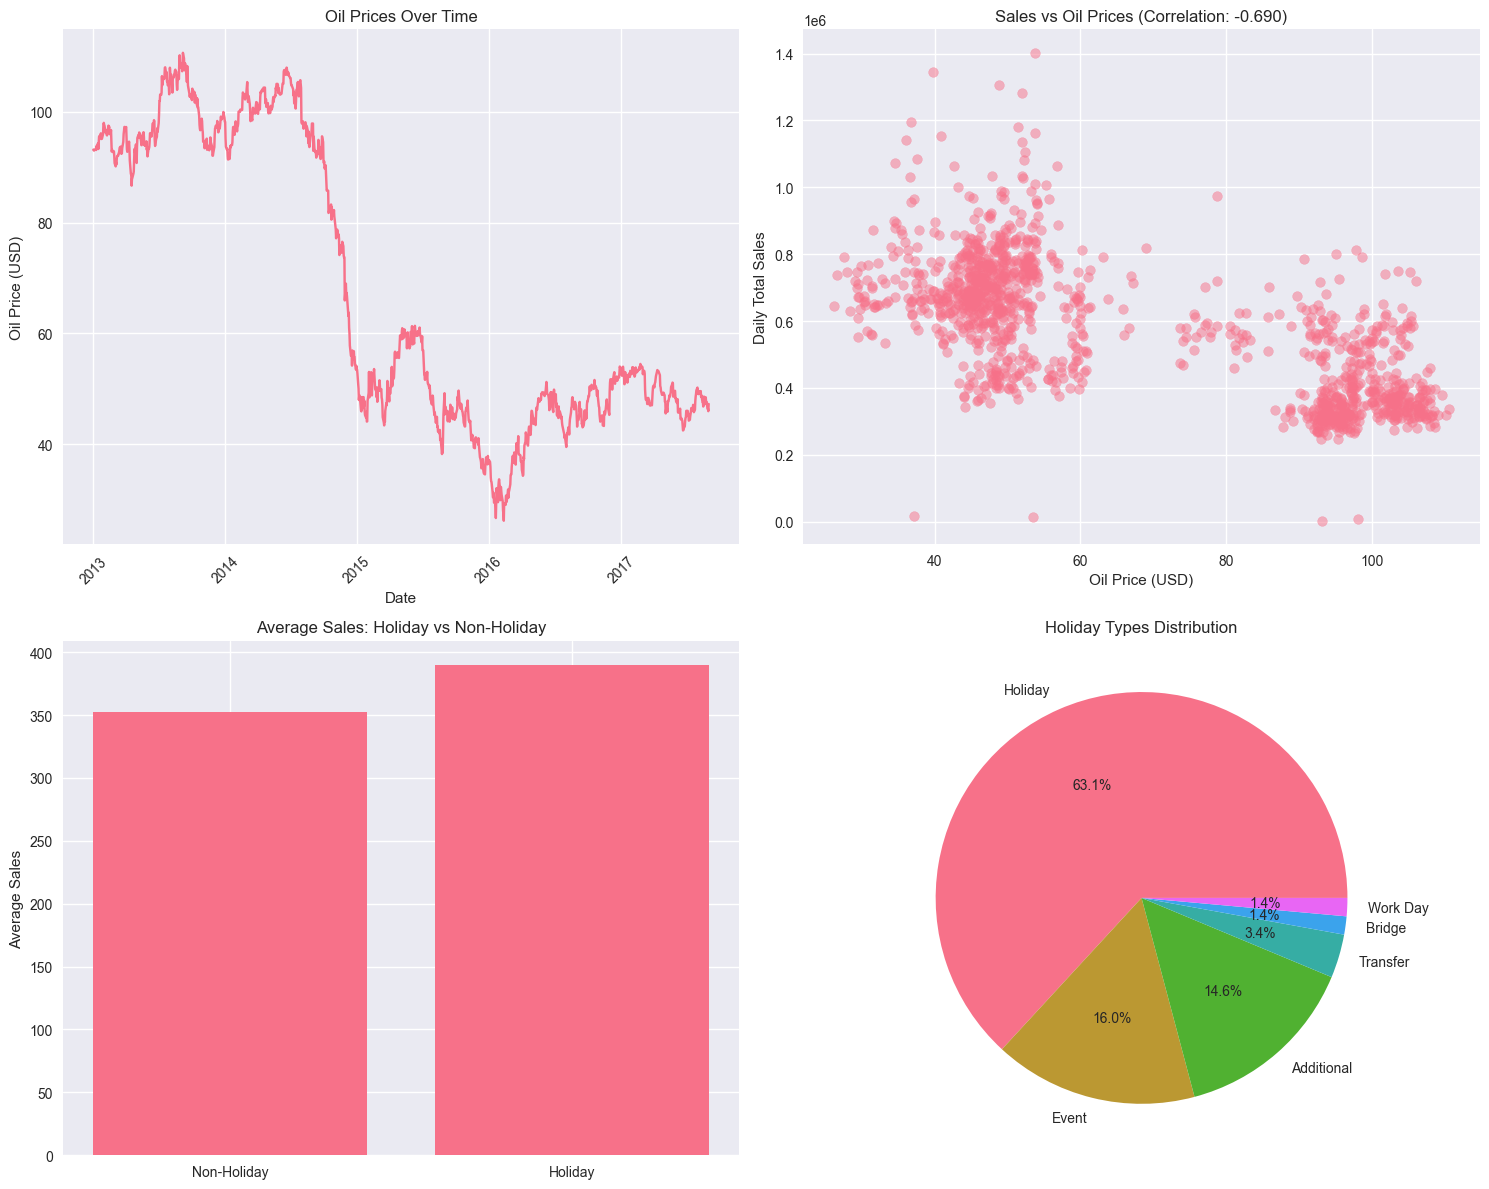

In [11]:
# Analyze oil prices and holidays impact
oil_df = data['oil']
holidays_df = data['holidays']

print("=== OIL PRICE ANALYSIS ===")
print(f"Oil price records: {len(oil_df)}")
print(f"Date range: {oil_df['date'].min()} to {oil_df['date'].max()}")
print(f"Missing oil prices: {oil_df['dcoilwtico'].isnull().sum()}")

# Fill missing oil prices with forward fill
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='ffill')
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='bfill')

print(f"Oil price statistics:")
print(oil_df['dcoilwtico'].describe())

print(f"\n=== HOLIDAYS ANALYSIS ===")
print(f"Holiday records: {len(holidays_df)}")
print(f"Holiday types: {holidays_df['type'].value_counts()}")
print(f"Holiday locales: {holidays_df['locale'].value_counts()}")

# Merge train data with oil prices and analyze correlation
train_with_oil = train_df.merge(oil_df, on='date', how='left')

# Calculate daily total sales for correlation with oil prices
daily_sales_oil = train_with_oil.groupby('date').agg({
    'sales': 'sum',
    'dcoilwtico': 'first'
}).reset_index()

# Remove rows with missing oil prices
daily_sales_oil = daily_sales_oil.dropna()

# Calculate correlation
oil_sales_corr = daily_sales_oil['sales'].corr(daily_sales_oil['dcoilwtico'])
print(f"\nCorrelation between oil prices and daily sales: {oil_sales_corr:.4f}")

# Analyze holidays impact
# Create holiday indicator
holidays_df['holiday_date'] = holidays_df['date']
holiday_dates = set(holidays_df['date'].dt.date)

train_with_holidays = train_df.copy()
train_with_holidays['is_holiday'] = train_with_holidays['date'].dt.date.isin(holiday_dates)

holiday_impact = train_with_holidays.groupby('is_holiday')['sales'].agg(['mean', 'sum', 'count'])
print(f"\n=== HOLIDAY IMPACT ===")
print(holiday_impact)

# Visualize external factors
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Oil prices over time
axes[0, 0].plot(oil_df['date'], oil_df['dcoilwtico'])
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Oil Price (USD)')
axes[0, 0].set_title('Oil Prices Over Time')
axes[0, 0].tick_params(axis='x', rotation=45)

# Sales vs oil prices scatter
axes[0, 1].scatter(daily_sales_oil['dcoilwtico'], daily_sales_oil['sales'], alpha=0.5)
axes[0, 1].set_xlabel('Oil Price (USD)')
axes[0, 1].set_ylabel('Daily Total Sales')
axes[0, 1].set_title(f'Sales vs Oil Prices (Correlation: {oil_sales_corr:.3f})')

# Holiday impact
holiday_means = [holiday_impact.loc[False, 'mean'], holiday_impact.loc[True, 'mean']]
axes[1, 0].bar(['Non-Holiday', 'Holiday'], holiday_means)
axes[1, 0].set_ylabel('Average Sales')
axes[1, 0].set_title('Average Sales: Holiday vs Non-Holiday')

# Holiday frequency by type
holiday_type_counts = holidays_df['type'].value_counts()
axes[1, 1].pie(holiday_type_counts.values, labels=holiday_type_counts.index, autopct='%1.1f%%')
axes[1, 1].set_title('Holiday Types Distribution')

plt.tight_layout()
plt.show()


## 6. Store Analysis and Geographical Patterns


=== STORE INFORMATION ===
Total Stores: 54
Store Types: type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64
Cities: 22
States: 16

Stores by City (Top 10):
city
Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Name: count, dtype: int64

Stores by State:
state
Pichincha                         19
Guayas                            11
Santo Domingo de los Tsachilas     3
Azuay                              3
Manabi                             3
Cotopaxi                           2
Tungurahua                         2
Los Rios                           2
El Oro                             2
Chimborazo                         1
Imbabura                           1
Bolivar                            1
Pastaza                            1
Santa Elena                        1
Loja                               1
Esmeraldas     

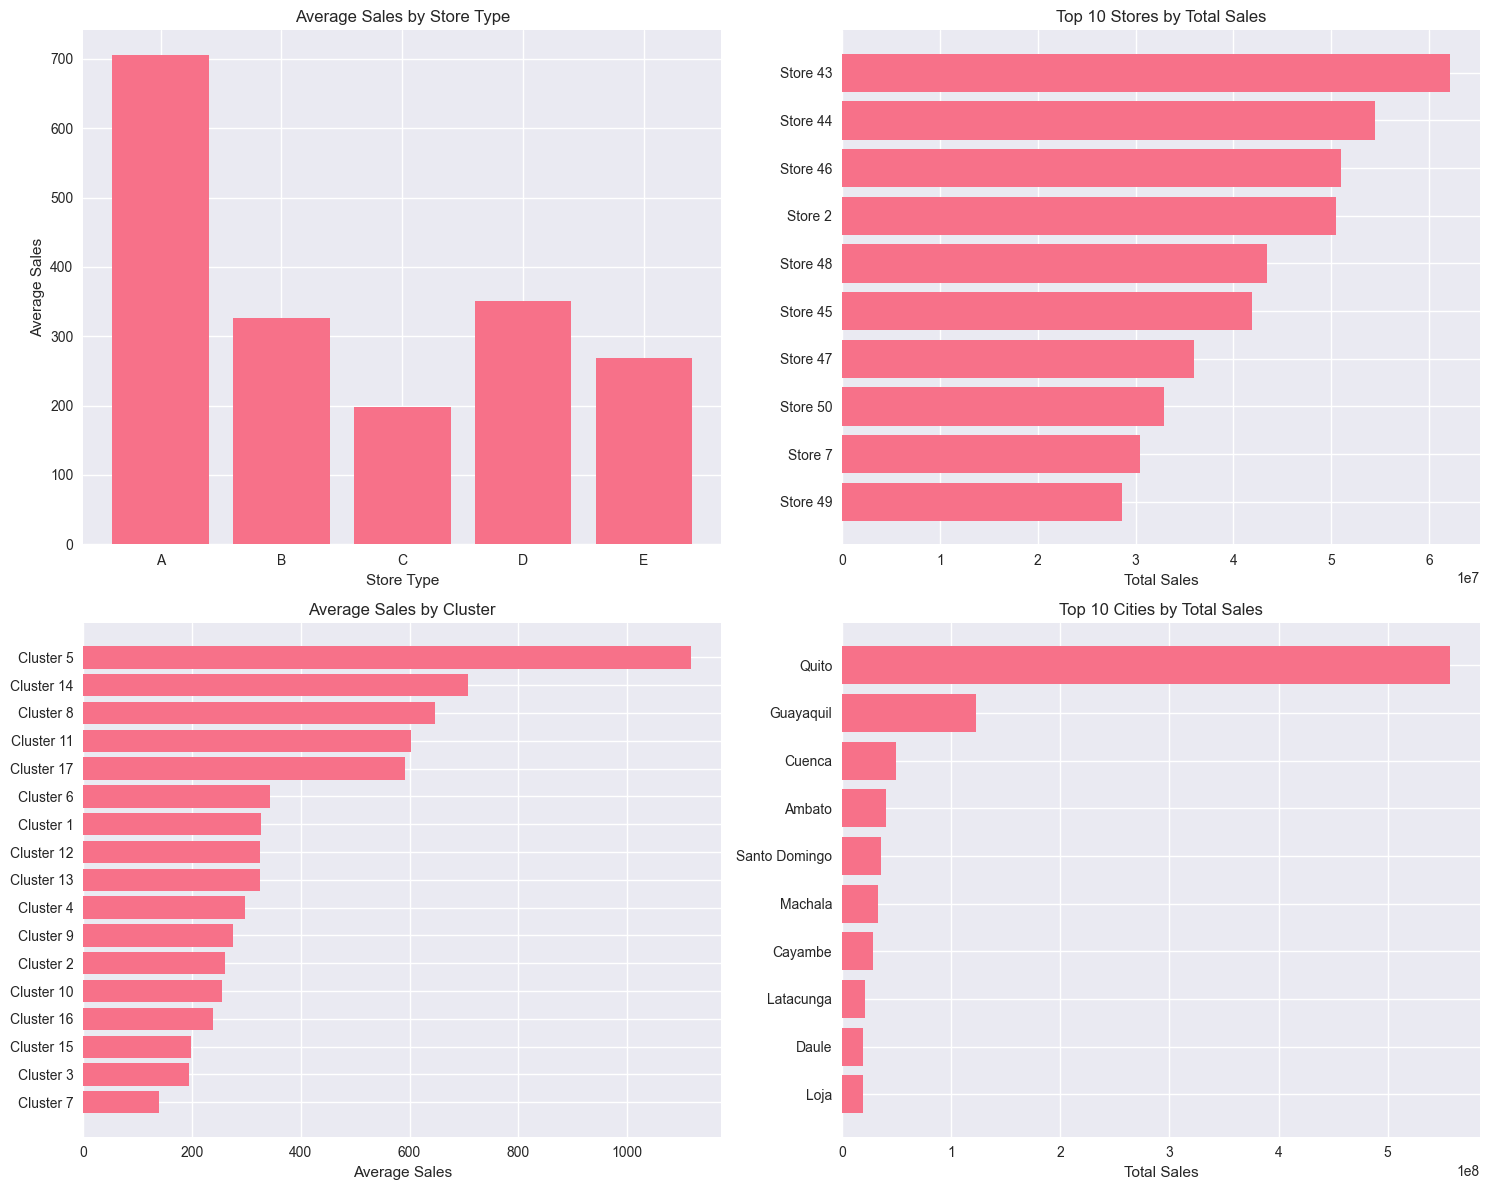

In [14]:
# Analyze store performance and geographical patterns
stores_df = data['stores']
transactions_df = data['transactions']

print("=== STORE INFORMATION ===")
print(f"Total Stores: {len(stores_df)}")
print(f"Store Types: {stores_df['type'].value_counts()}")
print(f"Cities: {stores_df['city'].nunique()}")
print(f"States: {stores_df['state'].nunique()}")

print(f"\nStores by City (Top 10):")
print(stores_df['city'].value_counts().head(10))

print(f"\nStores by State:")
print(stores_df['state'].value_counts())

print(f"\nStore Types Distribution:")
print(stores_df['type'].value_counts())

print(f"\nClusters Distribution:")
print(stores_df['cluster'].value_counts().sort_index())

# Merge train data with store information
train_with_stores = train_df.merge(stores_df, on='store_nbr', how='left')

# Analyze sales by store characteristics
store_performance = train_with_stores.groupby('store_nbr').agg({
    'sales': ['sum', 'mean', 'std'],
    'onpromotion': 'mean'
}).round(2)

store_performance.columns = ['Total_Sales', 'Mean_Sales', 'Std_Sales', 'Promotion_Rate']
store_performance = store_performance.merge(stores_df, on='store_nbr', how='left')
store_performance = store_performance.sort_values('Total_Sales', ascending=False)

print(f"\n=== TOP 10 PERFORMING STORES ===")
print(store_performance[['Total_Sales', 'Mean_Sales', 'city', 'state', 'type', 'cluster']].head(10))

# Analyze by store characteristics
type_performance = train_with_stores.groupby('type')['sales'].agg(['sum', 'mean', 'count'])
cluster_performance = train_with_stores.groupby('cluster')['sales'].agg(['sum', 'mean', 'count'])
city_performance = train_with_stores.groupby('city')['sales'].agg(['sum', 'mean', 'count']).sort_values('sum', ascending=False)

print(f"\n=== PERFORMANCE BY STORE TYPE ===")
print(type_performance)

print(f"\n=== PERFORMANCE BY CLUSTER ===")
print(cluster_performance.sort_values('sum', ascending=False))

print(f"\n=== TOP 10 CITIES BY SALES ===")
print(city_performance.head(10))

# Visualize store analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Store type performance
axes[0, 0].bar(type_performance.index, type_performance['mean'])
axes[0, 0].set_xlabel('Store Type')
axes[0, 0].set_ylabel('Average Sales')
axes[0, 0].set_title('Average Sales by Store Type')

# Top 10 stores performance
top_stores = store_performance.head(10)
axes[0, 1].barh(range(len(top_stores)), top_stores['Total_Sales'])
axes[0, 1].set_yticks(range(len(top_stores)))
axes[0, 1].set_yticklabels([f"Store {store}" for store in top_stores.index])
axes[0, 1].set_xlabel('Total Sales')
axes[0, 1].set_title('Top 10 Stores by Total Sales')
axes[0, 1].invert_yaxis()


# Cluster performance
cluster_perf_sorted = cluster_performance.sort_values('mean', ascending=True)
axes[1, 0].barh(range(len(cluster_perf_sorted)), cluster_perf_sorted['mean'])
axes[1, 0].set_yticks(range(len(cluster_perf_sorted)))
axes[1, 0].set_yticklabels([f"Cluster {cluster}" for cluster in cluster_perf_sorted.index])
axes[1, 0].set_xlabel('Average Sales')
axes[1, 0].set_title('Average Sales by Cluster')

# Top cities performance
top_cities = city_performance.head(10)
axes[1, 1].barh(range(len(top_cities)), top_cities['sum'])
axes[1, 1].set_yticks(range(len(top_cities)))
axes[1, 1].set_yticklabels(top_cities.index)
axes[1, 1].set_xlabel('Total Sales')
axes[1, 1].set_title('Top 10 Cities by Total Sales')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()


## 7. Key Insights and EDA Conclusions

### Data Characteristics
1. **Large Dataset**: 3M+ training records across 54 stores and 33 product families
2. **Time Span**: 4+ years of historical data (2013-2017)
3. **Missing Values**: Oil prices have some missing values that need imputation
4. **Sales Distribution**: Highly skewed with many zero sales, suggesting need for careful handling

### Sales Patterns
1. **Temporal Trends**: Clear seasonal patterns with higher sales in certain months
2. **Day-of-Week Effects**: Weekend vs weekday sales patterns
3. **Product Family Performance**: Significant variation in sales across product families
4. **Promotional Impact**: Products on promotion show different sales patterns

### External Factors
1. **Oil Prices**: Moderate correlation with sales, important for Ecuador's economy
2. **Holidays**: Impact on sales varies by holiday type and location
3. **Geographical Patterns**: Quito dominates sales, significant variation by store type and cluster